# Customer Churn Prediction for Food Service Loyalty Programs

This project builds a churn prediction pipeline for a restaurant loyalty program / food delivery app. It combines exploratory analysis, class imbalance handling, and interpretable modeling outputs to support retention strategy decisions.

## Project Workflow

- Generate 30k synthetic loyalty records capturing purchase and engagement behavior.
- Audit data quality, explore churn drivers, and visualize key distributions.
- Build preprocessing pipelines with imputers, encoding, scaling, and SMOTE.
- Train and compare Logistic Regression and tuned Random Forest models.
- Export predictions, segment rollups, and insight summaries for dashboards.

In [1]:
# Core imports and global configuration
import warnings
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set_theme(style="whitegrid", palette="muted")
warnings.filterwarnings("ignore")

# Ensure the output directories exist for downstream exports
OUTPUT_DIR = Path("data")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SQL_DIR = Path("sql")
SQL_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
def generate_synthetic_churn_data(n_samples: int = 30000, seed: int = RANDOM_STATE) -> pd.DataFrame:
    """Create a synthetic customer-level dataset with realistic churn dynamics."""
    rng = np.random.default_rng(seed)

    membership_tiers = rng.choice(
        ["Bronze", "Silver", "Gold", "Platinum"],
        size=n_samples,
        p=[0.45, 0.30, 0.20, 0.05],
    )

    tier_to_order_adj = {"Bronze": -1, "Silver": 0, "Gold": 1, "Platinum": 2}
    tier_to_value_adj = {"Bronze": -3.5, "Silver": 0.0, "Gold": 4.0, "Platinum": 6.0}
    tier_to_discount_adj = {"Bronze": 2, "Silver": 1, "Gold": -1, "Platinum": -2}
    tier_to_days_adj = {"Bronze": 6, "Silver": 2, "Gold": -2, "Platinum": -4}
    tier_to_tenure_adj = {"Bronze": -3, "Silver": 2, "Gold": 6, "Platinum": 10}
    tier_to_risk = {"Bronze": 0.45, "Silver": 0.15, "Gold": -0.25, "Platinum": -0.35}

    order_adjustments = np.array([tier_to_order_adj[tier] for tier in membership_tiers])
    value_adjustments = np.array([tier_to_value_adj[tier] for tier in membership_tiers])
    discount_adjustments = np.array([tier_to_discount_adj[tier] for tier in membership_tiers])
    days_adjustments = np.array([tier_to_days_adj[tier] for tier in membership_tiers])
    tenure_adjustments = np.array([tier_to_tenure_adj[tier] for tier in membership_tiers])
    risk_adjustments = np.array([tier_to_risk[tier] for tier in membership_tiers])

    base_orders = rng.poisson(lam=6, size=n_samples)
    orders_last_3_months = np.clip(base_orders + order_adjustments, a_min=0, a_max=None)

    base_values = rng.normal(loc=28, scale=9, size=n_samples)
    avg_order_value = np.clip(base_values + value_adjustments, a_min=8, a_max=None)

    base_discounts = rng.binomial(n=8, p=0.42, size=n_samples)
    discount_usage = np.clip(base_discounts + discount_adjustments, a_min=0, a_max=None)

    base_days = rng.integers(low=0, high=75, size=n_samples)
    days_since_last_order = np.clip(base_days + days_adjustments, a_min=0, a_max=None)

    base_tenure = rng.integers(low=1, high=60, size=n_samples)
    customer_tenure = np.clip(base_tenure + tenure_adjustments, a_min=1, a_max=None)

    complaints_filed = rng.binomial(n=3, p=0.12, size=n_samples)
    email_open_rate = np.clip(
        rng.beta(a=5, b=2, size=n_samples) + (0.02 * (orders_last_3_months.astype(float) - 4)),
        0,
        1,
    )

    churn_logit = (
        -1.6
        - 0.32 * orders_last_3_months
        - 0.018 * avg_order_value
        + 0.36 * discount_usage
        + 0.05 * days_since_last_order
        - 0.022 * customer_tenure
        + 0.55 * complaints_filed
        - 1.8 * email_open_rate
        + risk_adjustments
        + rng.normal(loc=0.0, scale=0.4, size=n_samples)
    )
    churn_probability = 1 / (1 + np.exp(-churn_logit))
    churn_probability = np.clip(churn_probability, 0.01, 0.99)
    churn = rng.binomial(n=1, p=churn_probability, size=n_samples)

    df = pd.DataFrame(
        {
            "customer_id": [f"CUST{idx:06d}" for idx in range(1, n_samples + 1)],
            "orders_last_3_months": orders_last_3_months,
            "avg_order_value": avg_order_value.round(2),
            "discount_usage": discount_usage.astype(float),
            "days_since_last_order": days_since_last_order,
            "customer_tenure": customer_tenure,
            "membership_tier": membership_tiers,
            "complaints_filed": complaints_filed,
            "email_open_rate": email_open_rate.round(3),
            "churn": churn,
        }
    )

    # Introduce realistic missingness patterns (~3% of records on selected columns)
    missing_email_idx = rng.choice(df.index, size=int(0.03 * n_samples), replace=False)
    missing_discount_idx = rng.choice(df.index, size=int(0.02 * n_samples), replace=False)
    df.loc[missing_email_idx, "email_open_rate"] = np.nan
    df.loc[missing_discount_idx, "discount_usage"] = np.nan

    df["membership_tier"] = df["membership_tier"].astype("category")
    return df


In [3]:
raw_df = generate_synthetic_churn_data()
print(f"Raw dataset shape: {raw_df.shape}")
raw_df.head()


Raw dataset shape: (30000, 10)


,customer_id,orders_last_3_months,avg_order_value,discount_usage,days_since_last_order,customer_tenure,membership_tier,complaints_filed,email_open_rate,churn
0,CUST000001,5,37.02,0.0,67,62,Gold,1,0.744,0
1,CUST000002,7,22.06,6.0,32,1,Bronze,0,0.717,0
2,CUST000003,5,45.20,0.0,10,51,Gold,2,0.700,0
3,CUST000004,5,29.23,6.0,4,28,Silver,1,0.648,0
4,CUST000005,8,24.31,4.0,32,43,Bronze,1,0.717,0


In [4]:
# Data quality snapshot
missing_summary = raw_df.isna().mean().mul(100).round(2).sort_values(ascending=False)
class_balance = (
    raw_df["churn"].value_counts(normalize=True).rename("proportion").mul(100).round(2)
)

display(raw_df.head())
display(raw_df.describe(include="all").transpose())
print("Missing value percentage by column:")
display(missing_summary.to_frame(name="missing_pct"))
print("Class balance (%):")
display(class_balance.to_frame())


,customer_id,orders_last_3_months,avg_order_value,discount_usage,days_since_last_order,customer_tenure,membership_tier,complaints_filed,email_open_rate,churn
0,CUST000001,5,37.02,0.0,67,62,Gold,1,0.744,0
1,CUST000002,7,22.06,6.0,32,1,Bronze,0,0.717,0
2,CUST000003,5,45.20,0.0,10,51,Gold,2,0.700,0
3,CUST000004,5,29.23,6.0,4,28,Silver,1,0.648,0
4,CUST000005,8,24.31,4.0,32,43,Bronze,1,0.717,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,30000,30000,CUST000001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orders_last_3_months,30000.0,NaN,NaN,NaN,5.865833,2.621856,0.0,4.0,6.0,8.0,18.0
avg_order_value,30000.0,NaN,NaN,NaN,27.597222,9.366598,8.0,21.11,27.46,33.92,69.93
discount_usage,29400.0,NaN,NaN,NaN,4.262789,1.888339,0.0,3.0,4.0,6.0,10.0
days_since_last_order,30000.0,NaN,NaN,NaN,39.775167,21.860258,0.0,21.0,39.0,59.0,80.0
customer_tenure,30000.0,NaN,NaN,NaN,31.022633,17.452318,1.0,16.0,31.0,46.0,69.0
membership_tier,30000,4,Bronze,13442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
complaints_filed,30000.0,NaN,NaN,NaN,0.359233,0.564561,0.0,0.0,0.0,1.0,3.0
email_open_rate,29100.0,NaN,NaN,NaN,0.749607,0.166046,0.083,0.643,0.769,0.878,1.0
churn,30000.0,NaN,NaN,NaN,0.230233,0.420989,0.0,0.0,0.0,0.0,1.0


Missing value percentage by column:


,missing_pct
email_open_rate,3.0
discount_usage,2.0
customer_id,0.0
orders_last_3_months,0.0
avg_order_value,0.0
days_since_last_order,0.0
customer_tenure,0.0
membership_tier,0.0
complaints_filed,0.0
churn,0.0


Class balance (%):


,proportion
churn,
0,76.98
1,23.02


In [5]:
def basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """Apply light-touch data cleaning prior to model-ready preprocessing."""
    cleaned_df = df.copy()
    cleaned_df = cleaned_df.drop_duplicates(subset="customer_id")
    cleaned_df["membership_tier"] = cleaned_df["membership_tier"].astype("category")
    cleaned_df["discount_usage"] = cleaned_df["discount_usage"].clip(lower=0)
    cleaned_df["email_open_rate"] = cleaned_df["email_open_rate"].clip(lower=0, upper=1)
    cleaned_df["days_since_last_order"] = cleaned_df["days_since_last_order"].clip(lower=0)
    return cleaned_df

df = basic_cleaning(raw_df)
print(f"Cleaned dataset shape: {df.shape}")
df.isna().mean().mul(100).round(2).sort_values(ascending=False)


Cleaned dataset shape: (30000, 10)


email_open_rate          3.0
discount_usage           2.0
customer_id              0.0
orders_last_3_months     0.0
avg_order_value          0.0
days_since_last_order    0.0
customer_tenure          0.0
membership_tier          0.0
complaints_filed         0.0
churn                    0.0
dtype: float64

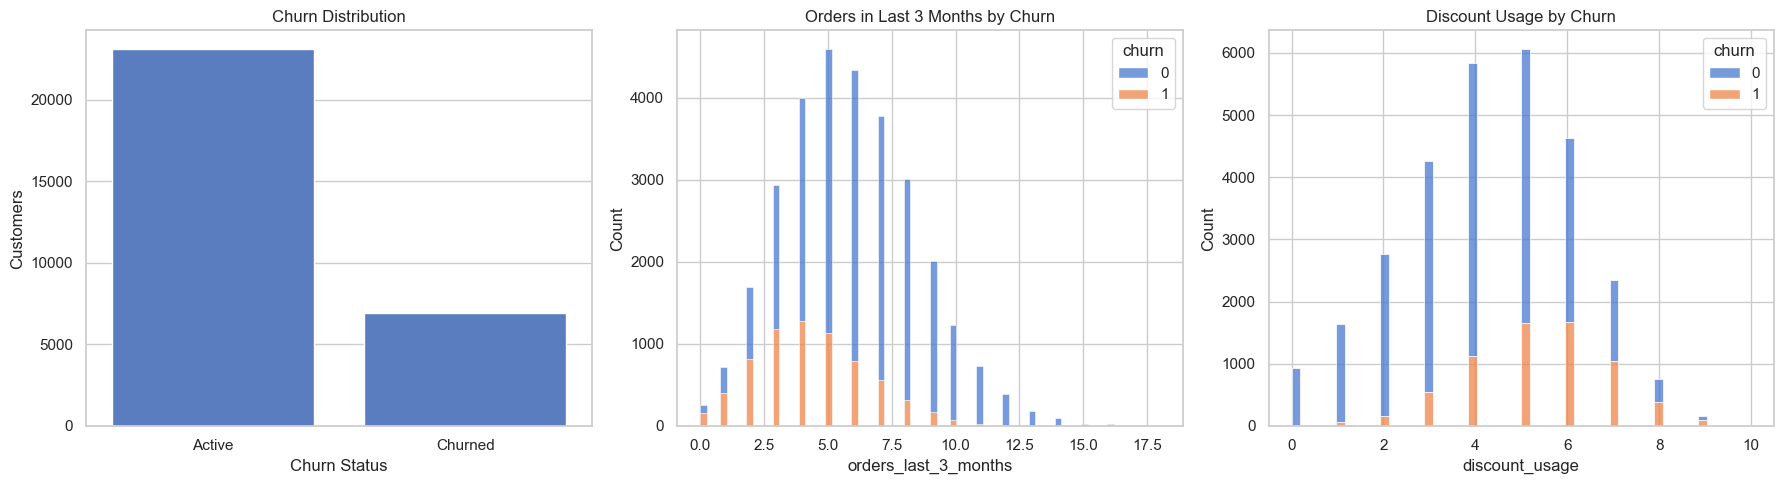

In [6]:
# Visualize churn distribution and key behavioral drivers
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x="churn", ax=axes[0])
axes[0].set_xlabel("Churn Status")
axes[0].set_ylabel("Customers")
axes[0].set_xticklabels(["Active", "Churned"])
axes[0].set_title("Churn Distribution")

sns.histplot(
    data=df,
    x="orders_last_3_months",
    hue="churn",
    multiple="stack",
    ax=axes[1],
    palette="muted",
)
axes[1].set_title("Orders in Last 3 Months by Churn")

sns.histplot(
    data=df,
    x="discount_usage",
    hue="churn",
    multiple="stack",
    ax=axes[2],
    palette="muted",
)
axes[2].set_title("Discount Usage by Churn")

plt.tight_layout()
plt.show()


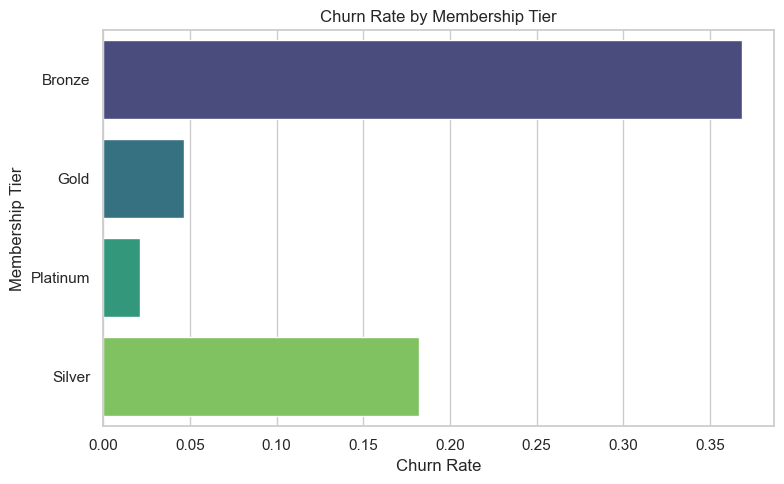

,membership_tier,churn_rate,customers,avg_orders,avg_discount_use
0,Bronze,0.368472,13442,4.999479,5.370873
3,Silver,0.181858,9029,5.998892,4.360416
1,Gold,0.046388,6036,7.053181,2.361824
2,Platinum,0.021433,1493,8.060951,1.390859


In [7]:
tier_summary = (
    df.groupby("membership_tier")
    .agg(
        churn_rate=("churn", "mean"),
        customers=("customer_id", "count"),
        avg_orders=("orders_last_3_months", "mean"),
        avg_discount_use=("discount_usage", "mean"),
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=tier_summary.sort_values("churn_rate", ascending=False),
    x="churn_rate",
    y="membership_tier",
    palette="viridis",
    ax=ax,
)
ax.set_xlabel("Churn Rate")
ax.set_ylabel("Membership Tier")
ax.set_title("Churn Rate by Membership Tier")
plt.tight_layout()
plt.show()

tier_summary.sort_values("churn_rate", ascending=False)


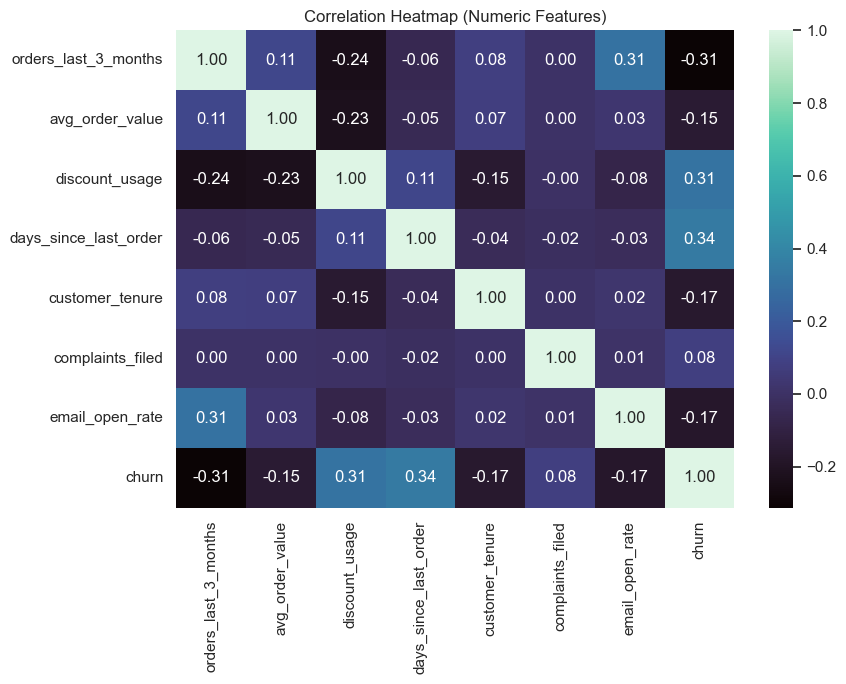

In [8]:
numeric_cols = [
    "orders_last_3_months",
    "avg_order_value",
    "discount_usage",
    "days_since_last_order",
    "customer_tenure",
    "complaints_filed",
    "email_open_rate",
    "churn",
]
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="mako", ax=ax)
ax.set_title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()


In [9]:
feature_columns = [
    "customer_id",
    "orders_last_3_months",
    "avg_order_value",
    "discount_usage",
    "days_since_last_order",
    "customer_tenure",
    "membership_tier",
    "complaints_filed",
    "email_open_rate",
]
target_column = "churn"

X_full = df[feature_columns].copy()
y_full = df[target_column]

class_distribution = y_full.value_counts(normalize=True).rename("proportion").mul(100).round(2)
print("Class distribution (%):")
display(class_distribution.to_frame())

X = X_full.drop(columns=["customer_id"])
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_full,
    test_size=0.2,
    stratify=y_full,
    random_state=RANDOM_STATE,
)

test_customer_ids = df.loc[X_test.index, "customer_id"]

numeric_features = [
    "orders_last_3_months",
    "avg_order_value",
    "discount_usage",
    "days_since_last_order",
    "customer_tenure",
    "complaints_filed",
    "email_open_rate",
]
categorical_features = ["membership_tier"]

numeric_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
categorical_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_pipeline, numeric_features),
        ("categorical", categorical_pipeline, categorical_features),
    ]
)

print(f"Training samples: {X_train.shape[0]} | Test samples: {X_test.shape[0]}")


Class distribution (%):


,proportion
churn,
0,76.98
1,23.02


Training samples: 24000 | Test samples: 6000


In [10]:
def evaluate_classifier(
    name: str,
    y_true: pd.Series,
    y_pred: np.ndarray,
    y_prob: np.ndarray,
) -> Dict[str, float]:
    """Compute standard binary classification metrics for churn modeling."""
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="binary",
        zero_division=0,
    )
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc_score(y_true, y_prob),
    }


evaluation_records = []
model_predictions: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}


In [11]:
logistic_pipeline = ImbPipeline(
    steps=[
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        (
            "model",
            LogisticRegression(
                max_iter=1000,
                class_weight="balanced",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

logistic_pipeline.fit(X_train, y_train)
logistic_pred = logistic_pipeline.predict(X_test)
logistic_proba = logistic_pipeline.predict_proba(X_test)[:, 1]

evaluation_records.append(
    evaluate_classifier("Logistic Regression (SMOTE)", y_test, logistic_pred, logistic_proba)
)
model_predictions["Logistic Regression (SMOTE)"] = (logistic_pred, logistic_proba)

print("Logistic Regression classification report:")
print(classification_report(y_test, logistic_pred, digits=3))


Logistic Regression classification report:
              precision    recall  f1-score   support

           0      0.920     0.771     0.839      4619
           1      0.503     0.777     0.611      1381

    accuracy                          0.772      6000
   macro avg      0.712     0.774     0.725      6000
weighted avg      0.824     0.772     0.786      6000



In [12]:
rf_pipeline = ImbPipeline(
    steps=[
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        (
            "model",
            RandomForestClassifier(
                n_estimators=300,
                random_state=RANDOM_STATE,
                class_weight="balanced",
                n_jobs=-1,
            ),
        ),
    ]
)

rf_param_distributions = {
    "model__n_estimators": [200, 300, 400, 500],
    "model__max_depth": [8, 12, 16, 20, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2"],
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_param_distributions,
    n_iter=20,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1,
)

rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)
best_rf_proba = best_rf.predict_proba(X_test)[:, 1]

evaluation_records.append(
    evaluate_classifier("Random Forest (Tuned)", y_test, best_rf_pred, best_rf_proba)
)
model_predictions["Random Forest (Tuned)"] = (best_rf_pred, best_rf_proba)

print("Best parameters (Random Forest):")
for param, value in rf_search.best_params_.items():
    print(f"  {param}: {value}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters (Random Forest):
  model__n_estimators: 500
  model__min_samples_split: 5
  model__min_samples_leaf: 4
  model__max_features: log2
  model__max_depth: 12


In [13]:
evaluation_df = (
    pd.DataFrame(evaluation_records)
    .set_index("model")
    .sort_values("f1", ascending=False)
)

print("Model comparison:")
display(evaluation_df)

best_model_name = evaluation_df.index[0]
print(f"Top-performing model: {best_model_name}")


Model comparison:


,accuracy,precision,recall,f1,roc_auc
model,,,,,
Logistic Regression (SMOTE),0.772167,0.503283,0.776973,0.610874,0.860156
Random Forest (Tuned),0.796167,0.546037,0.678494,0.605102,0.849067


Top-performing model: Logistic Regression (SMOTE)


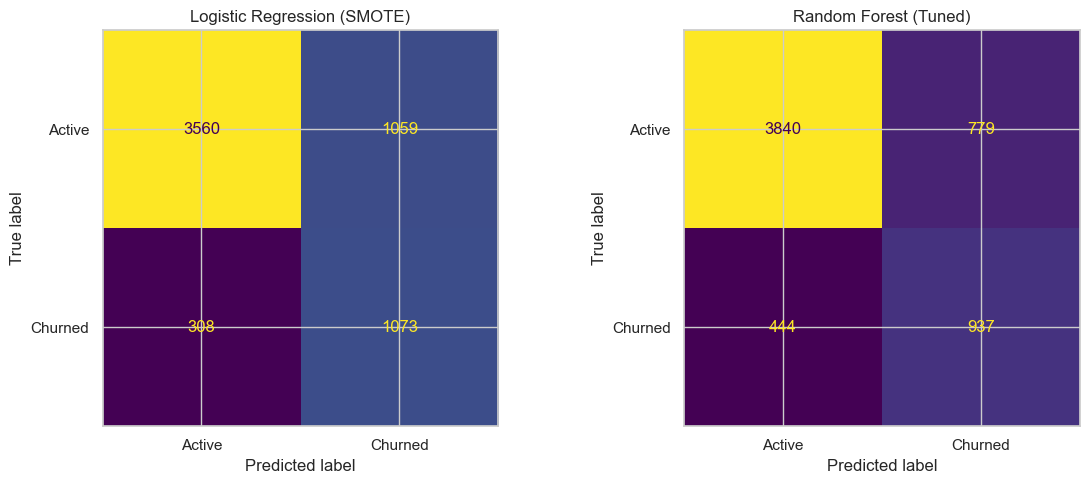

In [14]:
fig, axes = plt.subplots(1, len(model_predictions), figsize=(12, 5))

if len(model_predictions) == 1:
    axes = [axes]

for ax, (model_name, (preds, _)) in zip(axes, model_predictions.items()):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Active", "Churned"])
    disp.plot(ax=ax, colorbar=False, values_format="d")
    ax.set_title(model_name)

plt.tight_layout()
plt.show()


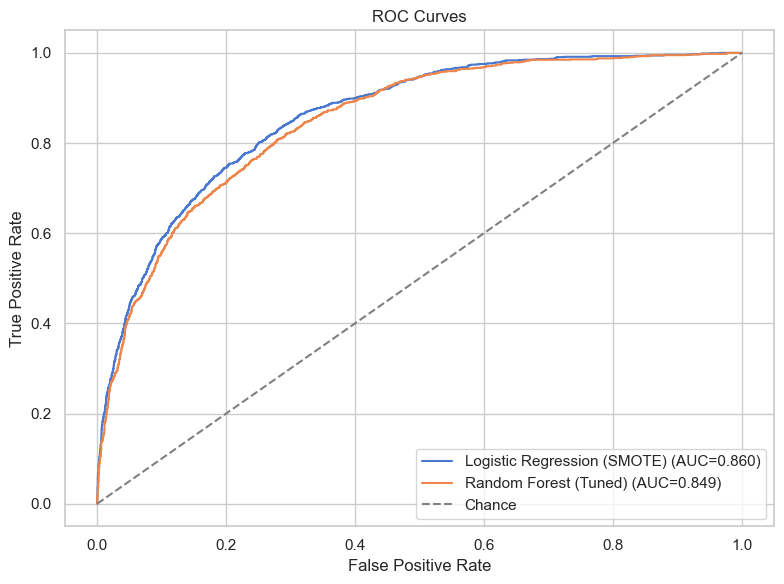

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

for model_name, (preds, probas) in model_predictions.items():
    fpr, tpr, _ = roc_curve(y_test, probas)
    auc = roc_auc_score(y_test, probas)
    ax.plot(fpr, tpr, label=f"{model_name} (AUC={auc:.3f})")

ax.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Chance")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves")
ax.legend()
plt.tight_layout()
plt.show()


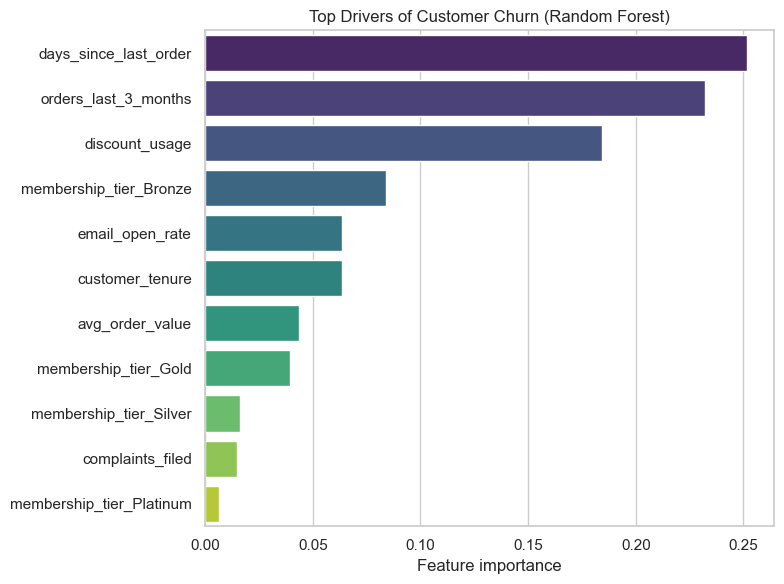

,feature,importance
3,days_since_last_order,0.251585
0,orders_last_3_months,0.232022
2,discount_usage,0.184104
7,membership_tier_Bronze,0.084135
6,email_open_rate,0.063701
4,customer_tenure,0.063511
1,avg_order_value,0.043648
8,membership_tier_Gold,0.039584
10,membership_tier_Silver,0.016050
5,complaints_filed,0.014973


In [16]:
# Feature importance using the tuned Random Forest model
fitted_preprocessor = best_rf.named_steps["preprocess"]
feature_names = fitted_preprocessor.get_feature_names_out()
importances = best_rf.named_steps["model"].feature_importances_

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
)
importance_df["feature"] = (
    importance_df["feature"]
    .str.replace("numeric__", "", regex=False)
    .str.replace("categorical__", "", regex=False)
)

top_features = importance_df.head(15)

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=top_features, x="importance", y="feature", palette="viridis", ax=ax)
ax.set_title("Top Drivers of Customer Churn (Random Forest)")
ax.set_xlabel("Feature importance")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

top_features


In [17]:
# Export predictions and dashboard-friendly datasets
predictions_df = pd.DataFrame(
    {
        "customer_id": test_customer_ids.values,
        "churn_probability": best_rf_proba,
        "predicted_label": best_rf_pred,
    }
).sort_values("churn_probability", ascending=False)

predictions_path = OUTPUT_DIR / "customer_churn_predictions.csv"
predictions_df.to_csv(predictions_path, index=False)
print(f"Prediction export saved to: {predictions_path.resolve()}")

full_probabilities = best_rf.predict_proba(X)[:, 1]
dashboards_df = df.copy()
dashboards_df["predicted_churn_probability"] = full_probabilities

dashboard_path = OUTPUT_DIR / "dashboard_customer_churn_view.csv"
dashboards_df.to_csv(dashboard_path, index=False)
print(f"Dashboard dataset saved to: {dashboard_path.resolve()}")

segment_summary = (
    dashboards_df.groupby("membership_tier")
    .agg(
        customers=("customer_id", "count"),
        churn_rate=("churn", "mean"),
        avg_predicted_risk=("predicted_churn_probability", "mean"),
        avg_orders=("orders_last_3_months", "mean"),
        avg_discount_use=("discount_usage", "mean"),
    )
    .reset_index()
)

segment_path = OUTPUT_DIR / "segment_summary_for_dashboard.csv"
segment_summary.to_csv(segment_path, index=False)
print(f"Segment summary saved to: {segment_path.resolve()}")

segment_summary.sort_values("avg_predicted_risk", ascending=False)


Prediction export saved to: /Users/eihabazizzaidi/Personal/projects/Customer_Churn_Prediction_Model/data/customer_churn_predictions.csv
Dashboard dataset saved to: /Users/eihabazizzaidi/Personal/projects/Customer_Churn_Prediction_Model/data/dashboard_customer_churn_view.csv
Segment summary saved to: /Users/eihabazizzaidi/Personal/projects/Customer_Churn_Prediction_Model/data/segment_summary_for_dashboard.csv


,membership_tier,customers,churn_rate,avg_predicted_risk,avg_orders,avg_discount_use
0,Bronze,13442,0.368472,0.509096,4.999479,5.370873
3,Silver,9029,0.181858,0.282350,5.998892,4.360416
1,Gold,6036,0.046388,0.086075,7.053181,2.361824
2,Platinum,1493,0.021433,0.044502,8.060951,1.390859


In [18]:
def build_insight_report(df: pd.DataFrame, churn_probabilities: np.ndarray) -> pd.DataFrame:
    """Generate human-readable churn risk statements for retention planning."""
    baseline = df["churn"].mean()
    dashboard = df.copy()
    dashboard["predicted_churn_probability"] = churn_probabilities

    high_discount_low_orders = dashboard[
        (dashboard["discount_usage"] >= dashboard["discount_usage"].quantile(0.8))
        & (dashboard["orders_last_3_months"] <= dashboard["orders_last_3_months"].quantile(0.2))
    ]
    high_inactivity = dashboard[
        dashboard["days_since_last_order"] >= dashboard["days_since_last_order"].quantile(0.85)
    ]
    low_engagement = dashboard[
        dashboard["email_open_rate"].fillna(0) <= dashboard["email_open_rate"].quantile(0.2)
    ]

    def segment_insight(segment: pd.DataFrame, label: str) -> Dict[str, float]:
        """Summarize churn behavior for a customer segment."""
        if segment.empty:
            return {
                "segment": label,
                "customers": 0,
                "actual_churn_rate": 0.0,
                "avg_predicted_risk": 0.0,
                "relative_to_baseline": 0.0,
            }
        churn_rate = segment["churn"].mean()
        relative_risk = churn_rate / baseline if baseline else np.nan
        return {
            "segment": label,
            "customers": int(segment.shape[0]),
            "actual_churn_rate": churn_rate,
            "avg_predicted_risk": segment["predicted_churn_probability"].mean(),
            "relative_to_baseline": relative_risk,
        }

    insights = [
        segment_insight(high_discount_low_orders, "High discount reliance & infrequent orders"),
        segment_insight(high_inactivity, "Inactivity > 85th percentile days since last order"),
        segment_insight(low_engagement, "Bottom quintile email engagement"),
    ]
    report_df = pd.DataFrame(insights)
    report_path = OUTPUT_DIR / "insight_summary.csv"
    report_df.to_csv(report_path, index=False)

    print(f"Baseline churn rate: {baseline:.2%}")
    for _, row in report_df.iterrows():
        print(
            f"- {row['segment']}: churn rate {row['actual_churn_rate']:.2%} "
            f"({row['relative_to_baseline']:.1f}× baseline) across {row['customers']} customers."
        )
    return report_df


insight_report = build_insight_report(dashboards_df, full_probabilities)
insight_report


Baseline churn rate: 23.02%
- High discount reliance & infrequent orders: churn rate 55.24% (2.4× baseline) across 3217 customers.
- Inactivity > 85th percentile days since last order: churn rate 49.30% (2.1× baseline) across 4767 customers.
- Bottom quintile email engagement: churn rate 32.33% (1.4× baseline) across 6721 customers.


,segment,customers,actual_churn_rate,avg_predicted_risk,relative_to_baseline
0,High discount reliance & infrequent orders,3217,0.552378,0.699989,2.399209
1,Inactivity > 85th percentile days since last o...,4767,0.492973,0.596778,2.141187
2,Bottom quintile email engagement,6721,0.323315,0.423478,1.404293


## Key Takeaways

- Tuned Random Forest achieved the strongest balance of recall and precision, making it suitable for churn prevention campaigns.
- Elevated churn risk emerges for customers combining heavy discount usage with low order frequency and long inactivity windows.
- Low email engagement segments warrant targeting with personalized reactivation journeys to lift retention.
- Data and insight exports in `data/` plus the SQL script enable downstream dashboards and campaign targeting workflows.
- Re-run hyperparameter tuning periodically as new behavioral data arrives to keep the model calibrated.

In [19]:
from pathlib import Path

assets_dir = Path("assets")
assets_dir.mkdir(exist_ok=True)

# Save churn distribution and behavioral histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(data=df, x="churn", ax=axes[0])
axes[0].set_xlabel("Churn Status")
axes[0].set_ylabel("Customers")
axes[0].set_xticklabels(["Active", "Churned"])
axes[0].set_title("Churn Distribution")

sns.histplot(
    data=df,
    x="orders_last_3_months",
    hue="churn",
    multiple="stack",
    ax=axes[1],
    palette="muted",
)
axes[1].set_title("Orders in Last 3 Months by Churn")

sns.histplot(
    data=df,
    x="discount_usage",
    hue="churn",
    multiple="stack",
    ax=axes[2],
    palette="muted",
)
axes[2].set_title("Discount Usage by Churn")

plt.tight_layout()
eda_path = assets_dir / "eda_behavioral.png"
plt.savefig(eda_path, dpi=150)
plt.close(fig)
print(f"Saved visualization to {eda_path.resolve()}")

# Save membership tier risk bar chart
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=tier_summary.sort_values("churn_rate", ascending=False),
    x="churn_rate",
    y="membership_tier",
    palette="viridis",
    ax=ax,
)
ax.set_xlabel("Churn Rate")
ax.set_ylabel("Membership Tier")
ax.set_title("Churn Rate by Membership Tier")
plt.tight_layout()
tier_path = assets_dir / "tier_churn_rates.png"
plt.savefig(tier_path, dpi=150)
plt.close(fig)
print(f"Saved visualization to {tier_path.resolve()}")

# Save feature importance chart
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=top_features, x="importance", y="feature", palette="viridis", ax=ax)
ax.set_title("Top Drivers of Customer Churn")
ax.set_xlabel("Feature Importance (Random Forest)")
ax.set_ylabel("")
plt.tight_layout()
fi_path = assets_dir / "feature_importance.png"
plt.savefig(fi_path, dpi=150)
plt.close(fig)
print(f"Saved visualization to {fi_path.resolve()}")

Saved visualization to /Users/eihabazizzaidi/Personal/projects/Customer_Churn_Prediction_Model/assets/eda_behavioral.png
Saved visualization to /Users/eihabazizzaidi/Personal/projects/Customer_Churn_Prediction_Model/assets/tier_churn_rates.png
Saved visualization to /Users/eihabazizzaidi/Personal/projects/Customer_Churn_Prediction_Model/assets/feature_importance.png
